In [1]:
from datasets import load_dataset, get_dataset_config_names
from transformers import AutoTokenizer, OPTForQuestionAnswering, GPTJForQuestionAnswering, XLNetForQuestionAnsweringSimple, GPT2Tokenizer, pipeline, AutoModelForQuestionAnswering
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Dataset
from haystack.document_stores import ElasticsearchDocumentStore
from haystack.nodes import BM25Retriever, EmbeddingRetriever, PromptNode, PromptTemplate, DensePassageRetriever,  FARMReader
from haystack.pipelines import GenerativeQAPipeline, Pipeline,  DocumentSearchPipeline, ExtractiveQAPipeline
from haystack import Label, Answer, Document
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

In [2]:
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [3]:
subjqa = load_dataset("subjqa", "tripadvisor")

Found cached dataset subjqa (C:/Users/EzLaser/.cache/huggingface/datasets/subjqa/tripadvisor/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 512
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 230
    })
})

In [5]:
subjqa["train"][0]

{'domain': 'tripadvisor',
 'nn_mod': 'awesome',
 'nn_asp': 'place',
 'query_mod': 'amazing',
 'query_asp': 'place',
 'q_reviews_id': '8ff9fa9cd9d246eeb73b26dbc9aa3b2e',
 'question_subj_level': 5,
 'ques_subj_score': 1.0,
 'is_ques_subjective': True,
 'review_id': 'tripadvisor_review_18201',
 'id': '074ee3857fe4a252088ae43606bd4cb9',
 'title': 'usa_san francisco_abigail_hotel',
 'context': "After reading the reviews I was expecting the worst... the hotel is comfortable, large rooms and friendly staff. Free breakfast was included which is a lot more than what we got in other much more expensive hotels we stayed in in California. The area which the hotel is in is indeed ghetto, drug dealers and users but they keep themselves to themselves. A bus or taxi is advisable to the centre as it is a distance to the main attractions. It is a budget hotel and doesn't claim to be anything else, worth the money and if you are travelling it is ideal. San Fran is really awesome ( least place we were loo

In [6]:
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")
     

Number of questions in train: 1165
Number of questions in test: 512
Number of questions in validation: 230


In [7]:
for index, row in dfs["train"].iterrows():
    if row["answers.text"].size == 0:
        dfs["train"].drop(axis=0, index=index, inplace=True)

len(dfs["train"])

686

In [8]:
dfs["train"].head(5)

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,tripadvisor,awesome,place,amazing,place,8ff9fa9cd9d246eeb73b26dbc9aa3b2e,5,1.00,True,tripadvisor_review_18201,074ee3857fe4a252088ae43606bd4cb9,usa_san francisco_abigail_hotel,After reading the reviews I was expecting the worst... the hotel is comforta...,How beautiful is the place?,[San Fran is really awesome],[555],[5],[1.0],[True]
3,tripadvisor,available,coffee,fresh,coffee,4aebc2ebb91a9d4d42e51aaddad1ebb0,1,0.00,False,tripadvisor_review_10984,f2a3151294ac189174d4efcf86ee7824,usa_san francisco_andrews_hotel,My husband and I recently had a very pleasant three night (Wed-Thurs-Fri) st...,How is coffee made?,[daily newspapers and coffee and tea available all day],[250],[1],[0.2],[False]
6,tripadvisor,small,desk,small,sink,4a71dd56e7ae949f499e3d55fa151f1d,5,0.65,True,tripadvisor_review_10996,beb3759a3717b1c9c81a3c35db198b3e,usa_san francisco_andrews_hotel,My wife and I visited the Andrews Hotel for three nights as an anniversary g...,Is the sink normal size?,[although we had to swap space in front of the mirror/sink],[1220],[5],[0.0],[False]
8,tripadvisor,great,wine tasting,great,wine hour,da46d7e86648c939f72089718c43119a,5,0.00,False,tripadvisor_review_1380,27f1bb97cfae6fc7efc73e031c2c490d,usa_san francisco_argonaut_hotel_a_kimpton_hotel,"This was a fantastic hotel. The location is perfect. The rooms are lovely, w...",How about wine hour?,"[The wine tasting each evening was a great end, The wine tasting each evenin...","[236, 236]","[5, 5]","[0.75, 0.75]","[True, True]"
9,tripadvisor,walking distance,attraction,close to,tourist attraction,6383f0ee5eb0fb64250db16fcd908513,5,0.00,False,tripadvisor_review_1468,ee38421ed964e2e89a618d2ab6e26513,usa_san francisco_argonaut_hotel_a_kimpton_hotel,"Overall, this is the nicest hotel I have ever stayed in. The hotel was extre...",What about the tourist attraction ?,[being close to attractions],[409],[5],[0.0],[False]


In [9]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=2)
sample_df

,title,question,answers.text,answers.answer_start,context
174,usa_san francisco_days_inn_lombard_street,How is the service?,"[Horrible service, Horrible service]","[0, 0]","Horrible service, the attendants were rude and unprofessional. When we arriv..."
357,usa_san francisco_hotel_adagio,How is the coffee?,"[lovely free coffee, lovely free coffee]","[127, 127]",our first time to San Francisco - the Adagio was the perfect central locatio...


In [10]:
start_idx = sample_df["answers.answer_start"].iloc[1][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[1][0])
sample_df["context"].iloc[1][start_idx:end_idx]

'lovely free coffee'

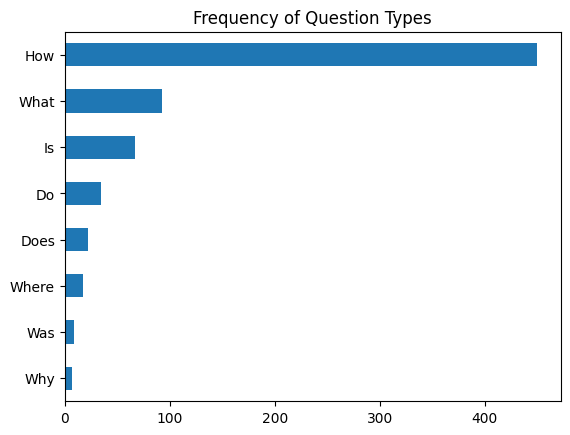

{'What': 93, 'How': 450, 'Is': 67, 'Does': 22, 'Do': 35, 'Was': 9, 'Where': 17, 'Why': 7}


In [11]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

print(counts)

In [12]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How was the bathroom in the room?
How is the quality of the service?
How is the quality of service?
What is the quality of the king bed?
What do you think about this place ?
What is the quality of the hotel?
Is it an excellent stay?
Is this bar excellent?
Is this neighborhood quiet?


# Store the dataset into ElasticsearchDocumentStore as a document

### Initializing a document store

In [13]:
# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(similarity="dot_product",embedding_dim=768)

In [14]:
#hide
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [15]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1172 documents


## Initializing a retriever

#### BM25 Retriever -> a variant of tf-idf

In [16]:
BM25_retriever = BM25Retriever(document_store=document_store, top_k=2)

In [17]:
item_id = "usa_san francisco_abigail_hotel"
query = "How is the service?"
retrieved_docs = BM25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [18]:
print(retrieved_docs[0])

<Document: id=cc9c07a76e16a214f42b7d015f485868, content='After reading the reviews I was expecting the worst... the hotel is comfortable, large rooms and fri...'>


## Evaluation for Retriever

Evaluating the retriever is the same as evaluating a `DocumentSearchPipeline`, which consists only of a single node, a retriever.

In [19]:
pipe = DocumentSearchPipeline(retriever=BM25_retriever)

In [20]:
labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})  
        labels.append(label)

In [21]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 724 question-answer pairs


In [22]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

413


In [23]:
# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [24]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.77


if we want to calculate metrics for multiple topk values, we can run the pipeline only once with the highest top_k value and calculate metrics for smaller top_ks afterwards

In [25]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:        
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(BM25_retriever)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\haystack\schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\haystack\schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\haystack\schema.py:1414: SettingWith

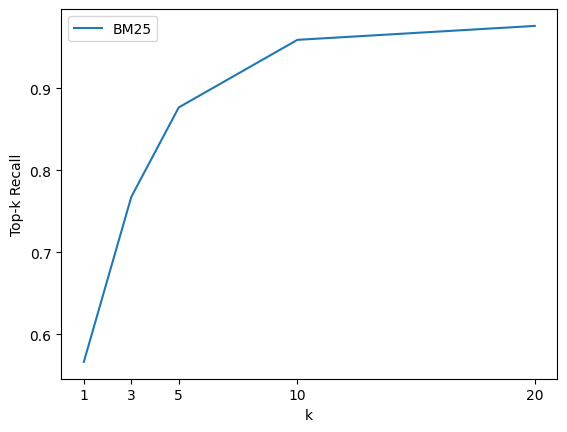

In [26]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

#### Dense Passage Retrieval

In [59]:
dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


In [60]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings:   0%|          | 0/1172 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1184 [00:00<?, ? Docs/s]

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\haystack\schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\haystack\schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\haystack\schema.py:1414: SettingWith

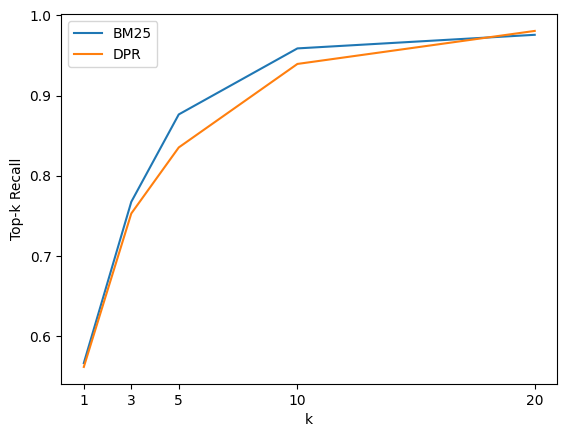

In [33]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

## Initializing a reader

In [27]:
reader_1 = FARMReader("deepset/roberta-base-squad2", progress_bar=False)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [30]:
max_seq_length, doc_stride = 384, 128

In [29]:
reader_2 = FARMReader("deepset/minilm-uncased-squad2", progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

In [30]:
reader_3 = FARMReader("ahotrod/albert_xxlargev1_squad2_512", progress_bar=False)

In [37]:
retriever_reader_pipe = ExtractiveQAPipeline(reader=reader_2, retriever=BM25_retriever)

In [38]:
n_answers = 3
preds = retriever_reader_pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"item_id": [item_id], "split":["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...")
    print("\n\n")

Question: How is the service? 

Answer 1: 
Review snippet: ...None...



Answer 2: free internet
Review snippet: ...ople desire for breakfast not stacks of pancakes and fried food. Well done Abigail for getting this right! Oh and there is free internet in the lobby....





IndexError: list index out of range

## Evaluate the Reader -> BM 25

### SquAD only

MiniLM

In [34]:
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

In [34]:
reader_eval = {}
reader_eval["MiniLM Fine-tune on SQuAD"] = evaluate_reader(reader_2)

In [38]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

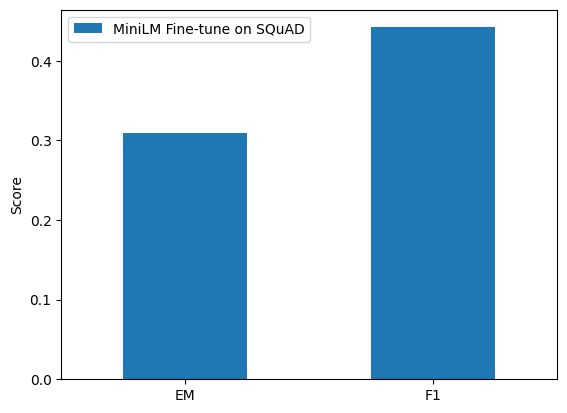

In [36]:
plot_reader_eval(reader_eval)

RoBERTa

In [37]:
reader_eval["RoBERTa Fine-tune on SQuAD"] = evaluate_reader(reader_1)

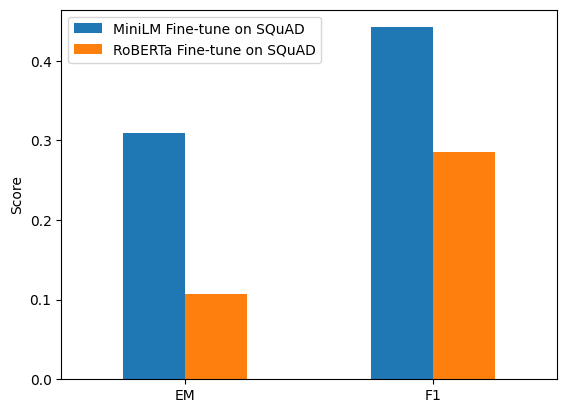

In [38]:
plot_reader_eval(reader_eval)

ALBERT

In [39]:
reader_eval["ALBERT Fine-tune on SQuAD"] = evaluate_reader(reader_3)

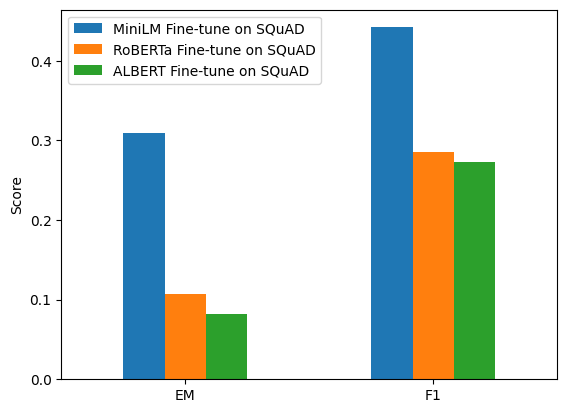

In [40]:
plot_reader_eval(reader_eval)

In [41]:
print(reader_eval)

{'MiniLM Fine-tune on SQuAD': {'exact_match': 0.3099273607748184, 'f1': 0.44213008900070633}, 'RoBERTa Fine-tune on SQuAD': {'exact_match': 0.10653753026634383, 'f1': 0.28498608019768623}, 'ALBERT Fine-tune on SQuAD': {'exact_match': 0.08232445520581114, 'f1': 0.27353894489171576}}


### SQuAD + SubjQA

In [63]:
reader_eval_1 = {}

In [28]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs
     

In [29]:
product = dfs["train"].query("title == 'usa_san francisco_abigail_hotel'")
create_paragraphs(product)

[{'qas': [{'question': 'How beautiful is the place?',
    'id': '074ee3857fe4a252088ae43606bd4cb9',
    'is_impossible': False,
    'answers': [{'text': 'San Fran is really awesome', 'answer_start': 555}]}],
  'context': "After reading the reviews I was expecting the worst... the hotel is comfortable, large rooms and friendly staff. Free breakfast was included which is a lot more than what we got in other much more expensive hotels we stayed in in California. The area which the hotel is in is indeed ghetto, drug dealers and users but they keep themselves to themselves. A bus or taxi is advisable to the centre as it is a distance to the main attractions. It is a budget hotel and doesn't claim to be anything else, worth the money and if you are travelling it is ideal. San Fran is really awesome ( least place we were looking forward to whilst travelling California) however it proved to be amazing. We cycled golden gate bridge, went to Alcatraz, countless bars and restaurants and lombard r

In [30]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"tripadvisor-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [31]:
train_filename = "tripadvisor-train.json"
dev_filename = "tripadvisor-validation.json"

MiniLM

In [ ]:
reader_1.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=4,
             train_filename=train_filename, dev_filename=dev_filename)

In [33]:
# save the model
reader_1.save("minilm_squad_subjqa")

In [32]:
# load the model 
reader_1 = FARMReader("minilm_squad_subjqa")

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": true, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}


In [ ]:
reader_eval_1["MiniLM Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader_1)

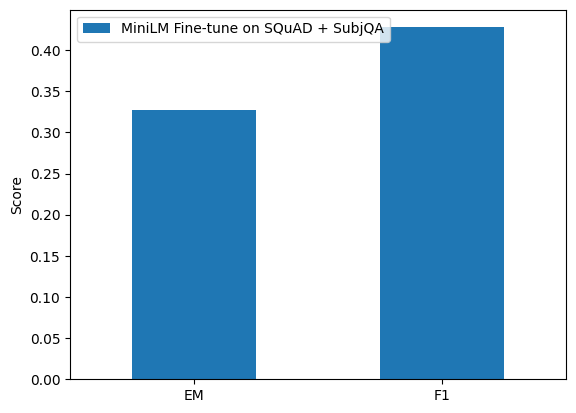

In [65]:
plot_reader_eval(reader_eval_1)

RoBERTa

In [36]:
reader_2.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=8,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/2 [00:00<?, ? Dicts/s]

Answer 'The staff were fantastic, the rooms were nice and the location was perfect for us. We were half a block from the Cable Car line (Powell St), a short walk to 24hr convienience stores/Starbucks and Union square and just a short stroll to shopping, great bars/restaurants (including Andrees). There was free internet access which was great for overseas guests, complimentary wine tasting every night in the bar and a cab ride to Fishermans Wharf was around $8. Chinatown was a short cab ride, so too is AT&amp;T Park for a Giants game. The only low light of SF was the amount of homeless people preying on you everytime you stop or pass them for money and the weather was unpredictable (not the Hotel Rexs' fault).Thumbs up from Oz ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Location is central and right by tram stop. Clean, quiet, very comfortable room which was just as good as a lot of 5 star hotels I've stayed in (minus certain

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Answer 'The employees are attentive, friendly and provides excellent service. And the room is very clean with nice amenities. Strongly recommended for leisure or business stay. Cheers ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Unable to convert 4 samples to features. Their ids are : 291-0-0, 225-0-0, 127-0-0, 92-0-0


In [37]:
# save the model
reader_2.save("roberta_squad_subjqa")

In [3]:
# load the model 
reader_2 = FARMReader("roberta_squad_subjqa")

Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": true, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}


In [ ]:
reader_eval_1["RoBERTa Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader_2)

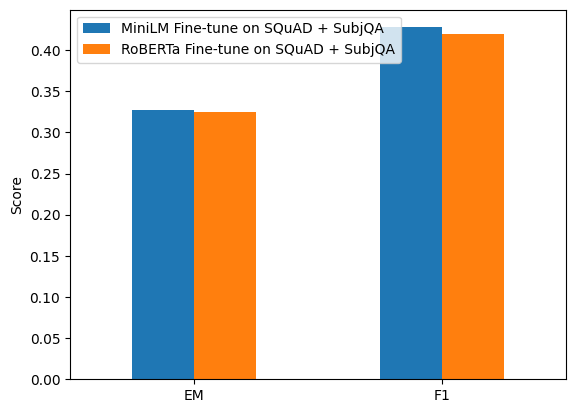

In [69]:
plot_reader_eval(reader_eval_1)

ALBERT

In [32]:
reader_3.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=1,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/2 [00:00<?, ? Dicts/s]

Answer 'The staff were fantastic, the rooms were nice and the location was perfect for us. We were half a block from the Cable Car line (Powell St), a short walk to 24hr convienience stores/Starbucks and Union square and just a short stroll to shopping, great bars/restaurants (including Andrees). There was free internet access which was great for overseas guests, complimentary wine tasting every night in the bar and a cab ride to Fishermans Wharf was around $8. Chinatown was a short cab ride, so too is AT&amp;T Park for a Giants game. The only low light of SF was the amount of homeless people preying on you everytime you stop or pass them for money and the weather was unpredictable (not the Hotel Rexs' fault).Thumbs up from Oz ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Location is central and right by tram stop. Clean, quiet, very comfortable room which was just as good as a lot of 5 star hotels I've stayed in (minus certain

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Answer 'The employees are attentive, friendly and provides excellent service. And the room is very clean with nice amenities. Strongly recommended for leisure or business stay. Cheers ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Unable to convert 4 samples to features. Their ids are : 291-0-0, 127-0-0, 225-0-0, 92-0-0


Evaluating:   0%|          | 0/385 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/385 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/385 [00:00<?, ?it/s]

In [33]:
# save the model
reader_3.save("albert_squad_subjqa")

In [70]:
# load the model 
reader_3 = FARMReader("albert_squad_subjqa")

Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": false, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}


In [ ]:
reader_eval_1["ALBERT Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader_3)

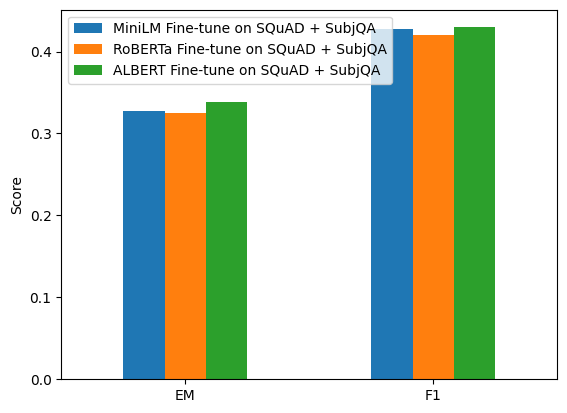

In [72]:
plot_reader_eval(reader_eval_1)

In [73]:
print(reader_eval_1)

{'MiniLM Fine-tune on SQuAD + SubjQA': {'exact_match': 0.3268765133171913, 'f1': 0.42767793478760124}, 'RoBERTa Fine-tune on SQuAD + SubjQA': {'exact_match': 0.324455205811138, 'f1': 0.41970906712111344}, 'ALBERT Fine-tune on SQuAD + SubjQA': {'exact_match': 0.3389830508474576, 'f1': 0.42962935058440627}}


### SubjQA

MiniLM

In [35]:
reader_eval_2 = {}

In [31]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=1,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/2 [00:00<?, ? Dicts/s]

Answer 'The staff were fantastic, the rooms were nice and the location was perfect for us. We were half a block from the Cable Car line (Powell St), a short walk to 24hr convienience stores/Starbucks and Union square and just a short stroll to shopping, great bars/restaurants (including Andrees). There was free internet access which was great for overseas guests, complimentary wine tasting every night in the bar and a cab ride to Fishermans Wharf was around $8. Chinatown was a short cab ride, so too is AT&amp;T Park for a Giants game. The only low light of SF was the amount of homeless people preying on you everytime you stop or pass them for money and the weather was unpredictable (not the Hotel Rexs' fault).Thumbs up from Oz ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'The hotel is in a great location in the financial district. We took the BART between SFO and the hotel. At $5.35 per person one way, it is more economical tha

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Answer 'The employees are attentive, friendly and provides excellent service. And the room is very clean with nice amenities. Strongly recommended for leisure or business stay. Cheers ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Unable to convert 5 samples to features. Their ids are : 398-0-0, 225-0-0, 127-0-0, 92-0-0, 291-0-0


Evaluating:   0%|          | 0/299 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/299 [00:00<?, ?it/s]

In [35]:
# save the model 
minilm_reader.save("minilm_subjqa")

In [ ]:
# load the model
minilm_reader = FARMReader("minilm_subjqa")

In [38]:
reader_eval_2["MiniLM Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)

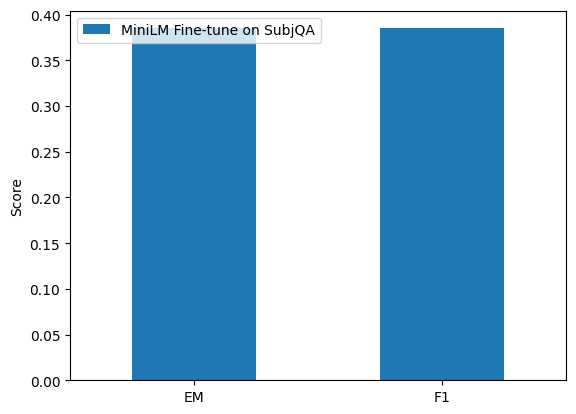

In [39]:
plot_reader_eval(reader_eval_2)

RoBERTa

In [39]:
roberta_ckpt = "roberta-base"
roberta_reader = FARMReader(model_name_or_path=roberta_ckpt, use_gpu=True, progress_bar=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

In [40]:
roberta_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=1,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/2 [00:00<?, ? Dicts/s]

Answer 'The staff were fantastic, the rooms were nice and the location was perfect for us. We were half a block from the Cable Car line (Powell St), a short walk to 24hr convienience stores/Starbucks and Union square and just a short stroll to shopping, great bars/restaurants (including Andrees). There was free internet access which was great for overseas guests, complimentary wine tasting every night in the bar and a cab ride to Fishermans Wharf was around $8. Chinatown was a short cab ride, so too is AT&amp;T Park for a Giants game. The only low light of SF was the amount of homeless people preying on you everytime you stop or pass them for money and the weather was unpredictable (not the Hotel Rexs' fault).Thumbs up from Oz ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Location is central and right by tram stop. Clean, quiet, very comfortable room which was just as good as a lot of 5 star hotels I've stayed in (minus certain

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Answer 'The employees are attentive, friendly and provides excellent service. And the room is very clean with nice amenities. Strongly recommended for leisure or business stay. Cheers ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Unable to convert 4 samples to features. Their ids are : 92-0-0, 225-0-0, 127-0-0, 291-0-0


Evaluating:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/377 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/377 [00:00<?, ?it/s]

In [41]:
# save the model
roberta_reader.save("roberta_subjqa")

In [ ]:
# load the model 
roberta_reader = FARMReader("roberta_subjqa")

In [42]:
reader_eval_2["RoBERTa Fine-tune on SubjQA"] = evaluate_reader(roberta_reader)

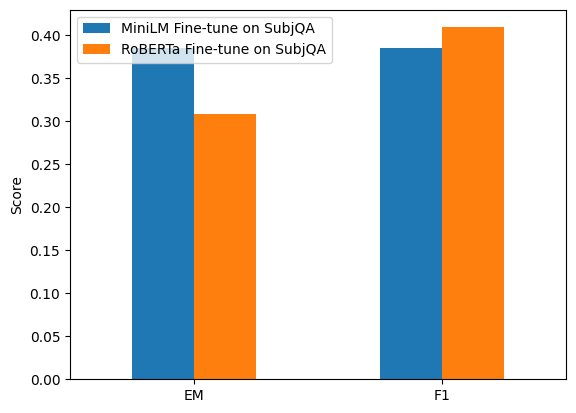

In [45]:
plot_reader_eval(reader_eval_2)

In [46]:
print(reader_eval_2)

{'MiniLM Fine-tune on SubjQA': {'exact_match': 0.38498789346246975, 'f1': 0.38498789346246975}, 'RoBERTa Fine-tune on SubjQA': {'exact_match': 0.3075060532687651, 'f1': 0.4087180273901269}}


ALBERT

In [27]:
albert_ckpt = "albert-xxlarge-v1"
albert_reader = FARMReader(model_name_or_path=albert_ckpt, use_gpu=True, progress_bar=False)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at albert-xxlarge-v1 were not used when initializing AlbertForQuestionAnswering: ['predictions.dense.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are 

In [30]:
albert_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=1,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/2 [00:00<?, ? Dicts/s]

Answer 'The staff were fantastic, the rooms were nice and the location was perfect for us. We were half a block from the Cable Car line (Powell St), a short walk to 24hr convienience stores/Starbucks and Union square and just a short stroll to shopping, great bars/restaurants (including Andrees). There was free internet access which was great for overseas guests, complimentary wine tasting every night in the bar and a cab ride to Fishermans Wharf was around $8. Chinatown was a short cab ride, so too is AT&amp;T Park for a Giants game. The only low light of SF was the amount of homeless people preying on you everytime you stop or pass them for money and the weather was unpredictable (not the Hotel Rexs' fault).Thumbs up from Oz ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Answer 'Location is central and right by tram stop. Clean, quiet, very comfortable room which was just as good as a lot of 5 star hotels I've stayed in (minus certain

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Answer 'The employees are attentive, friendly and provides excellent service. And the room is very clean with nice amenities. Strongly recommended for leisure or business stay. Cheers ANSWERNOTFOUND' not contained in context.
Example will not be converted for training/evaluation.
Unable to convert 4 samples to features. Their ids are : 127-0-0, 225-0-0, 291-0-0, 92-0-0


Evaluating:   0%|          | 0/385 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/385 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/385 [00:00<?, ?it/s]

In [31]:
# save the model
albert_reader.save("albert_subjqa")

In [ ]:
# load the model
albert_reader = FARMReader("albert_subjqa")

In [37]:
reader_eval_2["ALBERT Fine-tune on SubjQA"] = evaluate_reader(albert_reader)

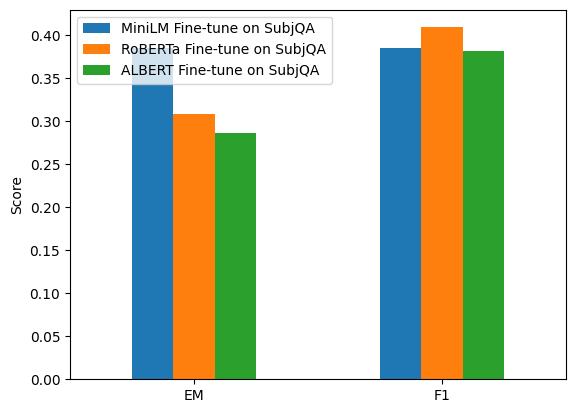

In [ ]:
plot_reader_eval(reader_eval_2)

In [38]:
print(reader_eval_2)

{'ALBERT Fine-tune on SubjQA': {'exact_match': 0.2857142857142857, 'f1': 0.39756349611114095}}


## Evaluating the Whole QA Pipeline (BM25 + Reader)

MiniLM

In [ ]:
reader_1 = FARMReader("minilm_squad_subjqa")

In [ ]:
pipe = ExtractiveQAPipeline(retriever=BM25_retriever, reader=reader_1)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval_1["QA Pipeline MiniLM (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

RoBERTa

In [ ]:
reader_2 = FARMReader("roberta_squad_subjqa")

In [ ]:
pipe = ExtractiveQAPipeline(retriever=BM25_retriever, reader=reader_2)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval_1["QA Pipeline RoBERTa (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

ALBERT

In [ ]:
reader_3 = FARMReader("albert_squad_subjqa")

In [ ]:
pipe = ExtractiveQAPipeline(retriever=BM25_retriever, reader=reader_3)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval_1["QA Pipeline ALBERT (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

Plot the bar chart for comparison

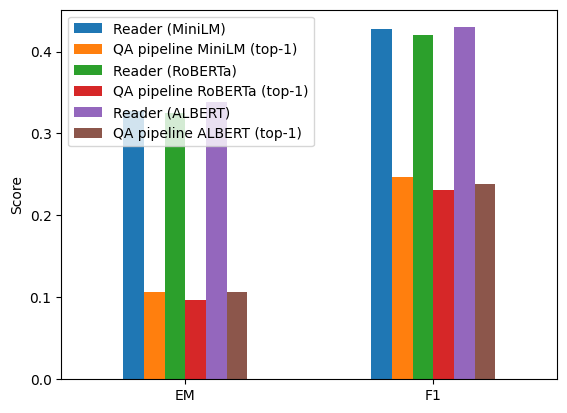

In [46]:
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader (MiniLM)": reader_eval_1["MiniLM Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline MiniLM (top-1)": reader_eval_1["QA Pipeline MiniLM (top-1)"],
                  "Reader (RoBERTa)": reader_eval_1["RoBERTa Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline RoBERTa (top-1)": reader_eval_1["QA Pipeline RoBERTa (top-1)"],
                  "Reader (ALBERT)": reader_eval_1["ALBERT Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline ALBERT (top-1)": reader_eval_1["QA Pipeline ALBERT (top-1)"]})
     

In [47]:
print({"Reader (MiniLM)": reader_eval_1["MiniLM Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline MiniLM (top-1)": reader_eval_1["QA Pipeline MiniLM (top-1)"],
                  "Reader (RoBERTa)": reader_eval_1["RoBERTa Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline RoBERTa (top-1)": reader_eval_1["QA Pipeline RoBERTa (top-1)"],
                  "Reader (ALBERT)": reader_eval_1["ALBERT Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline ALBERT (top-1)": reader_eval_1["QA Pipeline ALBERT (top-1)"]})

{'Reader (MiniLM)': {'exact_match': 0.3268765133171913, 'f1': 0.42767793478760124}, 'QA pipeline MiniLM (top-1)': {'exact_match': 0.10653753026634383, 'f1': 0.2462874528801869}, 'Reader (RoBERTa)': {'exact_match': 0.324455205811138, 'f1': 0.41970906712111344}, 'QA pipeline RoBERTa (top-1)': {'exact_match': 0.09685230024213075, 'f1': 0.2307522003768195}, 'Reader (ALBERT)': {'exact_match': 0.3389830508474576, 'f1': 0.42962935058440627}, 'QA pipeline ALBERT (top-1)': {'exact_match': 0.10653753026634383, 'f1': 0.23810162453226746}}


## Evaluating the Whole QA Pipeline (DPR + Reader)

MiniLM

In [61]:
reader_1 = FARMReader("minilm_squad_subjqa")

Some unused parameters are passed to the QuestionAnsweringHead. Might not be a problem. Params: {"training": true, "num_labels": 2, "ph_output_type": "per_token_squad", "model_type": "span_classification", "label_tensor_name": "question_answering_label_ids", "label_list": ["start_token", "end_token"], "metric": "squad", "name": "QuestionAnsweringHead"}


In [ ]:
pipe = ExtractiveQAPipeline(retriever=dpr_retriever, reader=reader_1)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval_1["QA Pipeline MiniLM (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

RoBERTa

In [ ]:
reader_2 = FARMReader("roberta_squad_subjqa")

In [ ]:
pipe = ExtractiveQAPipeline(retriever=dpr_retriever, reader=reader_2)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval_1["QA Pipeline RoBERTa (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

ALBERT

In [ ]:
reader_3 = FARMReader("albert_squad_subjqa")

In [ ]:
pipe = ExtractiveQAPipeline(retriever=dpr_retriever, reader=reader_3)

# Evaluate!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval_1["QA Pipeline ALBERT (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

Plot the bar chart for comparison

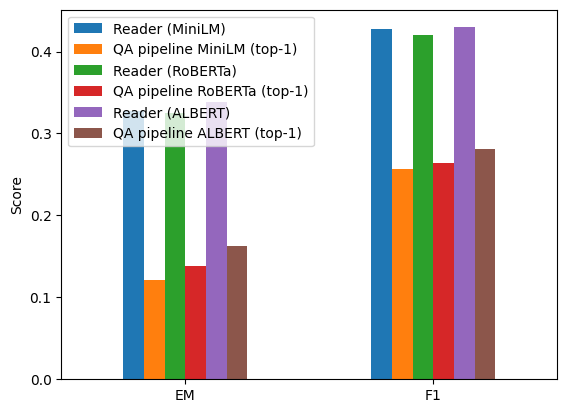

In [77]:
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader (MiniLM)": reader_eval_1["MiniLM Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline MiniLM (top-1)": reader_eval_1["QA Pipeline MiniLM (top-1)"],
                  "Reader (RoBERTa)": reader_eval_1["RoBERTa Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline RoBERTa (top-1)": reader_eval_1["QA Pipeline RoBERTa (top-1)"],
                  "Reader (ALBERT)": reader_eval_1["ALBERT Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline ALBERT (top-1)": reader_eval_1["QA Pipeline ALBERT (top-1)"]})
     

In [78]:
print({"Reader (MiniLM)": reader_eval_1["MiniLM Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline MiniLM (top-1)": reader_eval_1["QA Pipeline MiniLM (top-1)"],
                  "Reader (RoBERTa)": reader_eval_1["RoBERTa Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline RoBERTa (top-1)": reader_eval_1["QA Pipeline RoBERTa (top-1)"],
                  "Reader (ALBERT)": reader_eval_1["ALBERT Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline ALBERT (top-1)": reader_eval_1["QA Pipeline ALBERT (top-1)"]})

{'Reader (MiniLM)': {'exact_match': 0.3268765133171913, 'f1': 0.42767793478760124}, 'QA pipeline MiniLM (top-1)': {'exact_match': 0.12106537530266344, 'f1': 0.2562197301630652}, 'Reader (RoBERTa)': {'exact_match': 0.324455205811138, 'f1': 0.41970906712111344}, 'QA pipeline RoBERTa (top-1)': {'exact_match': 0.13801452784503632, 'f1': 0.26349773809510485}, 'Reader (ALBERT)': {'exact_match': 0.3389830508474576, 'f1': 0.42962935058440627}, 'QA pipeline ALBERT (top-1)': {'exact_match': 0.162227602905569, 'f1': 0.28090820253621}}


## Generator

### Initializing the PromptNode

In [27]:
lfqa_prompt = PromptTemplate(
    name="lfqa",
    prompt_text="""Synthesize a comprehensive answer from the following text for the given question. 
                             Provide a clear and concise response that summarizes the key points and information presented in the text. 
                             Your answer should be in your own words and be no longer than 50 words. 
                             \n\n Related text: {join(documents)} \n\n Question: {query} \n\n Answer:""",
)

prompt_node = PromptNode("google/flan-t5-large", default_prompt_template=lfqa_prompt)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Creating the Retriever-Generator Pipeline

In [28]:
pipe = Pipeline()
pipe.add_node(component=BM25_retriever, name="retriever", inputs=["Query"])
pipe.add_node(component=prompt_node, name="prompt_node", inputs=["retriever"])

## Asking a question based on the data stored in the document store

In [29]:
preds = pipe.run(query=query)
print(f"Question: {preds['query']} \n")
print(f"Answer : {preds['results']}")
print("\n\n")

Question: How is the service? 

Answer : ['The concierge will respond to your every request very promptly and eagerly.']





In [46]:
results = dfs["train"].loc[dfs["train"]["question"] == query]

print(len(results))

16


In [47]:
for i in results:
    print(results["answers.text"])

174                                                [Horrible service, Horrible service]
184                              [the service was fantastic, the service was fantastic]
186                                               [fantastic, The service is fantastic]
189                                        [the horrible service, the horrible service]
190                                               [Service was impeccable and reliable]
302     [had a very nice time here and would definitely stay here again on my next v...
579                              [service was exceptional, The service was exceptional]
596                                          [The service was bad, The service was bad]
632        [room service was great and the food was so good, The service was excellent]
681                         [the service was excellent, This was a real disappointment]
686                  [The service and concierge were exceptional and went out of their]
704                             

In [61]:
print(f"Question: {preds['query']} \n")
print(f"Answer : {preds['results']}")
print("\n")

for index, rows in results.iterrows():
    print(rows["answers.text"][0], " = " , False if rows["answers.text"][0] != preds['results'][0] else True)

Question: How is the service? 

Answer : ['The concierge will respond to your every request very promptly and eagerly.']


Horrible service  =  False
the service was fantastic  =  False
fantastic  =  False
the horrible service  =  False
Service was impeccable and reliable  =  False
had a very nice time here and would definitely stay here again on my next visit  =  False
service was exceptional  =  False
The service was bad  =  False
room service was great and the food was so good  =  False
the service was excellent  =  False
The service and concierge were exceptional and went out of their  =  False
service to be impeccable  =  False
Service was outstanding  =  False
for Service and the Best Luxury Hotel  =  False
the service was super  =  False
great find. Nice value  =  False
